In [1]:
import pyro
import torch
import torch.nn as nn
import numpy as np
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample
import matplotlib.pyplot as plt
from pyro.infer import MCMC, NUTS
from pyro.infer import Predictive

In [2]:
torch.manual_seed(42)
np.random.seed(42)

In [3]:
# Dataset generation
X = np.linspace(0, 1, 300)
noise = np.random.normal(0, 0.25, 300)
y = np.sin(2 * np.pi * X) + noise

X = torch.tensor(X, dtype=torch.float)
y = torch.tensor(y, dtype=torch.float)

y_true = torch.tensor(np.sin(2 * np.pi * X.clone()), dtype=torch.float)

C:\Users\nokze\AppData\Local\Temp\ipykernel_8976\2624116347.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_true = torch.tensor(np.sin(2 * np.pi * X.clone()), dtype=torch.float)


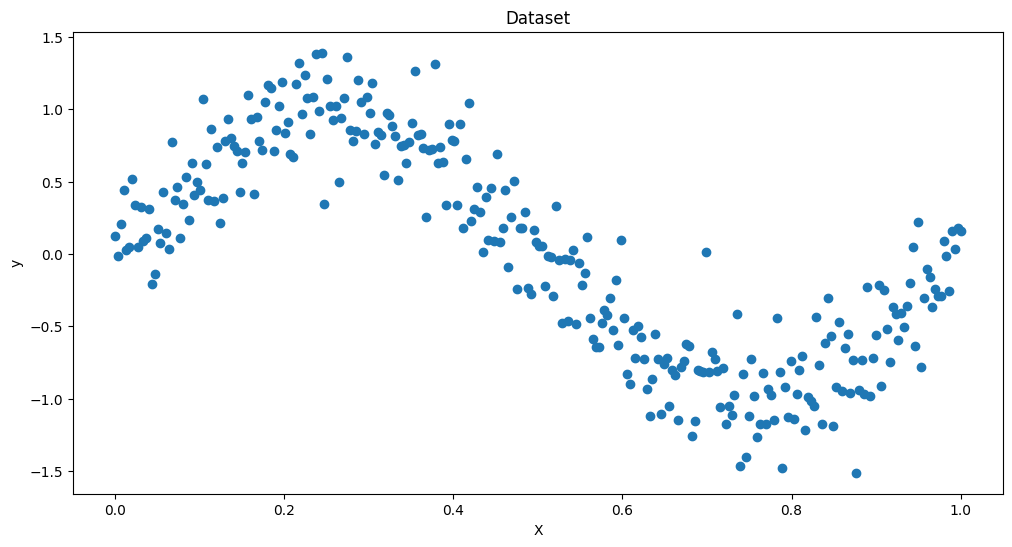

In [4]:
# Plotting the dataset
plt.figure(figsize=(12, 6))
plt.plot(X.numpy(), y.numpy(), 'o')
plt.title("Dataset")
plt.xlabel("X")
plt.ylabel("y")
plt.show()

In [5]:
class NeuralNet(PyroModule):
    def __init__(self, in_dim=1, out_dim=1, hid_dim=5, prior_scale=1.0):
        super().__init__()

        self.activation = nn.Tanh()  # or nn.ReLU()
        self.layer1 = PyroModule[nn.Linear](in_dim, hid_dim)  # Input to hidden layer
        self.layer2 = PyroModule[nn.Linear](hid_dim, out_dim)  # Hidden to output layer

        # Set layer parameters as random variables
        self.layer1.weight = PyroSample(dist.Normal(0., prior_scale).expand([hid_dim, in_dim]).to_event(2))
        self.layer1.bias = PyroSample(dist.Normal(0., prior_scale).expand([hid_dim]).to_event(1))
        self.layer2.weight = PyroSample(dist.Normal(0., prior_scale).expand([out_dim, hid_dim]).to_event(2))
        self.layer2.bias = PyroSample(dist.Normal(0., prior_scale).expand([out_dim]).to_event(1))

    def forward(self, x, y=None):
        x = x.reshape(-1, 1)
        x = self.activation(self.layer1(x))
        mu = self.layer2(x).squeeze()
        sigma = pyro.sample("sigma", dist.Gamma(.5, 1))  # Infer the response noise

        # Sampling model
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Normal(mu, sigma), obs=y)
        return obs

In [6]:
model = NeuralNet()

# Set Pyro random seed
pyro.set_rng_seed(42)

# Define Hamiltonian Monte Carlo (HMC) kernel
# NUTS = "No-U-Turn Sampler" (https://arxiv.org/abs/1111.4246), gives HMC an adaptive step size
nuts_kernel = NUTS(model, jit_compile=False)  # jit_compile=True is faster but requires PyTorch 1.6+

# Define MCMC sampler, get 50 posterior samples
mcmc = MCMC(nuts_kernel, num_samples=50)

# Run MCMC
mcmc.run(X, y)

Sample: 100%|██████████| 100/100 [02:56,  1.76s/it, step size=7.98e-03, acc. prob=0.711]


In [7]:
predictive = Predictive(model=model, posterior_samples=mcmc.get_samples())
x_test = torch.linspace(-0.2, 1.2, 1000)
model_preds = predictive(x_test)

In [8]:
def plot_predictions(preds):
    y_pred = preds['obs'].T.detach().numpy().mean(axis=1)
    y_std = preds['obs'].T.detach().numpy().std(axis=1)

    fig, ax = plt.subplots(figsize=(10, 5))
    plt.xlabel("X")
    plt.ylabel("Y")

    ax.plot(X, y_true, 'b-', linewidth=4, label="true function")
    ax.plot(X, y, 'ko', markersize=4, label="observations")
    ax.plot(x_test, y_pred, '-', linewidth=2, color="#408765", label="predictive mean")
    ax.fill_between(x_test, y_pred - 2 * y_std, y_pred + 2 * y_std, alpha=0.6, color='#86cfac', zorder=5, label = "95% CI")

    # Plot the standard deviation of the predictions independently
    ax.fill_between(x_test, -y_std, y_std, alpha=0.6, color='brown', label = "predictive std")

    plt.legend(loc=4, frameon=False)

In [68]:
model_preds['obs'].shape

torch.Size([50, 1000])

In [76]:
model_preds

{'obs': tensor([[-1.6486,  0.0541, -0.1830,  ..., -0.2515, -1.0364, -1.8317],
         [ 0.0704, -0.7035, -0.7918,  ..., -1.9528, -1.9216,  0.9841],
         [-2.6576,  0.0776, -0.0887,  ...,  0.3450, -1.1575,  2.0160],
         ...,
         [-0.2197,  0.2920, -0.9943,  ..., -3.5338, -1.2959, -0.9859],
         [-1.1687,  0.6084, -0.6387,  ..., -0.6463, -0.4161,  1.7153],
         [-0.9401, -0.6820,  1.7122,  ..., -1.7504,  3.1324,  2.6820]])}

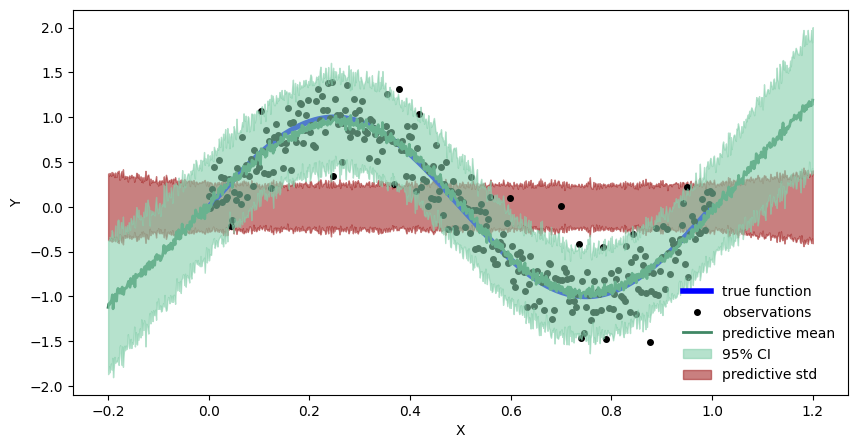

In [9]:
plot_predictions(model_preds)

In [10]:
# Keep only the first 50 and last 50 datapoints of the dataset
X_subset = X[0:50]
y_subset = y[0:50]

X_retained = torch.cat((X_subset, X[250:300]), 0)
y_retained = torch.cat((y_subset, y[250:300]), 0)

In [11]:
# Saving the Deleted data for later use
X_deleted = X[50:250]
y_deleted = y[50:250]

In [12]:
ret_model = NeuralNet()

# Set Pyro random seed
pyro.set_rng_seed(42)

# Define Hamiltonian Monte Carlo (HMC) kernel
# NUTS = "No-U-Turn Sampler" (https://arxiv.org/abs/1111.4246), gives HMC an adaptive step size
nuts_kernel = NUTS(ret_model, jit_compile=False)  # jit_compile=True is faster but requires PyTorch 1.6+

# Define MCMC sampler, get 50 posterior samples
mcmc_ret = MCMC(nuts_kernel, num_samples=50)

# Run MCMC
mcmc_ret.run(X_retained, y_retained)

Sample: 100%|██████████| 100/100 [03:08,  1.88s/it, step size=4.53e-03, acc. prob=0.977]


In [13]:
predictive = Predictive(model=ret_model, posterior_samples=mcmc_ret.get_samples())
x_test = torch.linspace(-0.2, 1.2, 1000)
ret_model_preds = predictive(x_test)

In [14]:
# Check the shape of preds
print(ret_model_preds['obs'].shape)

torch.Size([50, 1000])


In [15]:
def plot_predictions(preds):
    y_pred = preds['obs'].T.detach().numpy().mean(axis=1)
    y_std = preds['obs'].T.detach().numpy().std(axis=1)

    fig, ax = plt.subplots(figsize=(10, 5))
    plt.xlabel("X")
    plt.ylabel("Y")

    ax.plot(X, y_true, 'b-', linewidth=4, label="true function")
    ax.plot(X_retained, y_retained, 'ko', markersize=4, label="observations")
    ax.plot(x_test, y_pred, 'g-', linewidth=2, color="green", label="predictive mean")
    ax.fill_between(x_test, y_pred - 2 * y_std, y_pred + 2 * y_std, alpha=0.6, color='#86cfac', zorder=5, label = "95% CI")

    # Plot the standard deviation of the predictions independently as a trace plot
    ax.fill_between(x_test, -y_std, y_std, alpha=0.6, color='brown', label = "predictive std")

    plt.legend(loc=4, frameon=False)

C:\Users\nokze\AppData\Local\Temp\ipykernel_8976\1713219004.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "g-" (-> color='g'). The keyword argument will take precedence.
  ax.plot(x_test, y_pred, 'g-', linewidth=2, color="green", label="predictive mean")


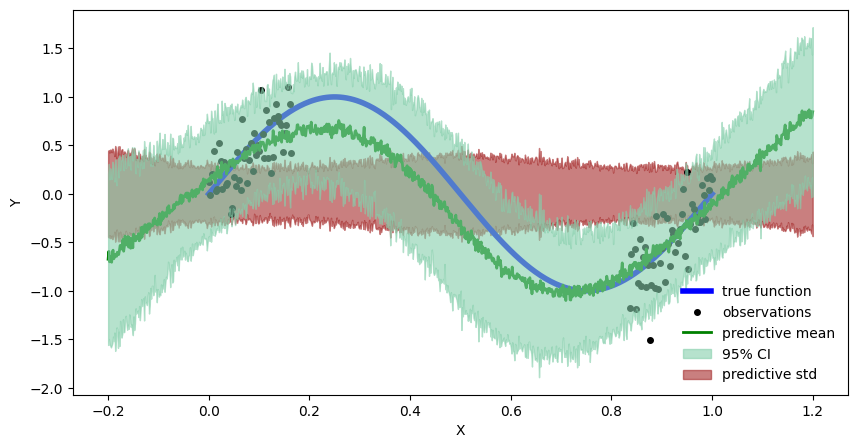

In [16]:
plot_predictions(ret_model_preds)

### Parameterizing the Posterior

In [17]:
mcmc.get_samples()

{'layer1.bias': tensor([[ 1.5776e-03,  1.7221e+00,  4.0939e-01, -9.6280e-01,  2.4399e+00],
         [ 1.8784e-01,  1.9721e+00,  9.0585e-02, -5.5742e-01,  2.7502e+00],
         [ 4.3665e-01,  1.9014e+00,  4.9988e-01, -1.4878e+00,  2.5503e+00],
         [-8.0515e-01,  1.5294e+00,  3.1653e-01,  1.2364e+00,  3.0505e+00],
         [-1.4913e+00,  1.5972e+00,  3.2458e-01,  1.1195e+00,  2.5360e+00],
         [-3.8919e-01,  1.9139e+00,  9.1567e-02, -2.8279e+00,  2.1414e+00],
         [-1.5801e+00,  1.8021e+00,  1.0547e-01,  2.6243e-01,  2.1722e+00],
         [-1.5554e+00,  1.8415e+00,  2.0193e-02,  3.4623e-01,  2.4608e+00],
         [-1.7153e+00,  1.6319e+00, -1.7446e-01,  9.6642e-02,  3.0120e+00],
         [ 1.2073e+00,  1.5256e+00,  3.0538e-01,  1.9369e+00,  2.7525e+00],
         [ 5.1008e-01,  1.5818e+00,  1.0253e-01,  2.4752e+00,  2.7657e+00],
         [-1.1340e+00,  2.0260e+00, -6.4462e-02,  9.0133e-02,  1.8599e+00],
         [ 1.1246e+00,  1.6198e+00,  1.6618e-01,  1.1462e-01,  2.6898e+00

In [18]:
# Get the covariance matrix of the mcmc samples
samples = mcmc.get_samples()

In [19]:
torch.flatten(samples['layer1.weight'], start_dim=1).shape

torch.Size([50, 5])

In [20]:
param_names = ['layer1.weight', 'layer1.bias', 'layer2.weight', 'layer2.bias']

cov_vals = []
mean_vals = []
for param_name in param_names:
    flat_param = torch.flatten(samples[param_name], start_dim=1)
    mean_vals.append(flat_param.detach().numpy().mean(axis=0))
    temp_cov = np.cov(flat_param.T.detach().numpy())
    # Store only the diagonal elements of the covariance matrix
    # Check if the temp_cov is a square matrix and not a single element
    if temp_cov.shape != ():
        cov_vals.append(np.diag(temp_cov))
    else:
        cov_vals.append(np.atleast_1d(temp_cov))

cov_vals, mean_vals


([array([1.2198495 , 0.06946334, 2.48223194, 3.10910979, 0.65661866]),
  array([1.81780441, 0.02156335, 0.13939732, 0.78247849, 0.48527691]),
  array([1.11821824, 0.08838002, 2.24869023, 2.13714745, 0.49121791]),
  array([0.49579456])],
 [array([-0.33305427, -3.525541  , -1.818953  , -0.9196742 , -2.468355  ],
        dtype=float32),
  array([ 0.59104055,  1.7857796 ,  0.07449889, -0.06331678,  2.520763  ],
        dtype=float32),
  array([-0.4185306,  2.8791413, -1.5534548, -0.5732222, -2.576661 ],
        dtype=float32),
  array([0.1563261], dtype=float32)])

In [21]:
mean_arr = []
for m in mean_vals:
    for i in m:
        mean_arr.append(i)

np.array(mean_arr)

array([-0.33305427, -3.525541  , -1.818953  , -0.9196742 , -2.468355  ,
        0.59104055,  1.7857796 ,  0.07449889, -0.06331678,  2.520763  ,
       -0.4185306 ,  2.8791413 , -1.5534548 , -0.5732222 , -2.576661  ,
        0.1563261 ], dtype=float32)

In [22]:
# Get the covariance matrix values from the cov_vals list
cov_mat = []
for p in cov_vals:
    for i in p:
        cov_mat.append(i)

# Create the covariance matrix using the cov_mat list as the diagonal entries
cov_mat = np.diag(cov_mat)
cov_mat

array([[1.2198495 , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.06946334, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 2.48223194, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 3.10910979, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.65661866,
        0.        , 0.        , 

In [23]:
# Get the posterior in parameteric form using the mean and covariance matrix calculated above. Use torch distributions
posterior = torch.distributions.MultivariateNormal(torch.tensor(mean_arr, dtype = torch.float), torch.tensor(cov_mat, dtype = torch.float))

In [24]:
# Get samples from the posterior
post_samples = posterior.sample((50,))
post_samples

tensor([[ 1.2835e+00, -3.4666e+00, -3.2284e+00, -1.6785e+00, -2.7858e+00,
          1.5145e+00,  2.0548e+00, -1.9454e-01,  4.6251e-01,  1.7454e+00,
         -1.7692e-01,  2.8888e+00, -7.1184e-01,  1.0177e+00, -2.1824e+00,
         -6.8685e-01],
        [-2.4261e+00, -3.8026e+00, -6.9682e+00, -2.4089e+00, -1.9311e+00,
         -1.3849e+00,  1.7352e+00,  7.1945e-02, -4.6508e-01,  2.5280e+00,
         -1.0132e+00,  2.7430e+00,  2.1488e-01, -2.3554e+00, -3.2275e+00,
          1.0739e-02],
        [-1.1606e+00, -2.9987e+00, -8.2090e-01,  1.4921e+00, -3.1375e+00,
         -1.2292e+00,  1.7849e+00,  7.4091e-02,  1.7387e-01,  2.2472e+00,
         -6.8154e-01,  2.6288e+00, -5.6556e-01,  1.0646e+00, -2.7446e+00,
         -6.2974e-01],
        [ 2.1767e-01, -3.7395e+00, -4.4177e+00, -4.1535e-01, -2.3098e+00,
         -7.5765e-01,  1.6103e+00,  7.2166e-02, -1.9089e+00,  2.4136e+00,
         -2.4351e-01,  3.0360e+00,  1.5385e+00,  5.4651e-01, -2.3823e+00,
         -1.0441e-01],
        [ 4.2244e-01

In [25]:
layer1weight_cov = np.diag(cov_vals[0])
layer1bias_cov = np.diag(cov_vals[1])
layer2weight_cov = np.diag(cov_vals[2])
layer2bias_cov = np.diag(cov_vals[3])

In [26]:
layer1weight_mean = mean_vals[0]
layer1bias_mean = mean_vals[1]
layer2weight_mean = mean_vals[2]
layer2bias_mean = mean_vals[3]

In [27]:
layer2weight_cov

array([[1.11821824, 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.08838002, 0.        , 0.        , 0.        ],
       [0.        , 0.        , 2.24869023, 0.        , 0.        ],
       [0.        , 0.        , 0.        , 2.13714745, 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.49121791]])

In [28]:
# Re-creating the full covariance matrix

param_names = ['layer1.weight', 'layer1.bias', 'layer2.weight', 'layer2.bias']

full_cov_vals = []
for param_name in param_names:
    flat_param = torch.flatten(samples[param_name], start_dim=1)
    temp_cov = np.cov(flat_param.T.detach().numpy())
    # Store only the diagonal elements of the covariance matrix
    # Check if the temp_cov is a square matrix and not a single element
    if temp_cov.shape != ():
        full_cov_vals.append(temp_cov)
    else:
        full_cov_vals.append(np.atleast_1d(temp_cov))

full_cov_vals

[array([[ 1.2198495 , -0.01573027,  0.13265574,  0.02118208, -0.31528883],
        [-0.01573027,  0.06946334,  0.0295858 , -0.10433003, -0.05487237],
        [ 0.13265574,  0.0295858 ,  2.48223194, -2.09785683, -0.19953053],
        [ 0.02118208, -0.10433003, -2.09785683,  3.10910979, -0.0082531 ],
        [-0.31528883, -0.05487237, -0.19953053, -0.0082531 ,  0.65661866]]),
 array([[ 1.81780441, -0.05339596, -0.19915855, -0.18784899, -0.00257141],
        [-0.05339596,  0.02156335, -0.0099057 , -0.03621568, -0.02764271],
        [-0.19915855, -0.0099057 ,  0.13939732,  0.00288001, -0.03762987],
        [-0.18784899, -0.03621568,  0.00288001,  0.78247849,  0.04681206],
        [-0.00257141, -0.02764271, -0.03762987,  0.04681206,  0.48527691]]),
 array([[ 1.11821824, -0.07815026,  0.04792032,  0.33515844, -0.28432706],
        [-0.07815026,  0.08838002, -0.00587797, -0.06517246,  0.02675095],
        [ 0.04792032, -0.00587797,  2.24869023, -1.26370053,  0.01625075],
        [ 0.33515844,

In [29]:
# Convert the numpy arrays to tensors
layer1weight_mean = torch.tensor(layer1weight_mean, dtype = torch.float)
layer1bias_mean = torch.tensor(layer1bias_mean, dtype = torch.float)
layer2weight_mean = torch.tensor(layer2weight_mean, dtype = torch.float)
layer2bias_mean = torch.tensor(layer2bias_mean, dtype = torch.float)

layer1weight_cov = torch.tensor(full_cov_vals[0], dtype = torch.float)
layer1bias_cov = torch.tensor(full_cov_vals[1], dtype = torch.float)
layer2weight_cov = torch.tensor(full_cov_vals[2], dtype = torch.float)
layer2bias_cov = torch.tensor(full_cov_vals[3], dtype = torch.float)

In [30]:
torch.sqrt(layer2bias_cov)

tensor([0.7041])

### Defining the model with the posterior

In [31]:
class LaplaceApproxNeuralNet(PyroModule):
    def __init__(self, in_dim=1, out_dim=1, hid_dim=5):
        super().__init__()

        self.activation = nn.Tanh()  # or nn.ReLU()
        self.layer1 = PyroModule[nn.Linear](in_dim, hid_dim)  # Input to hidden layer
        self.layer2 = PyroModule[nn.Linear](hid_dim, out_dim)  # Hidden to output layer

        # Set layer parameters as random variables
        self.layer1.weight = PyroSample(dist.MultivariateNormal(layer1weight_mean, layer1weight_cov))
        self.layer1.bias = PyroSample(dist.MultivariateNormal(layer1bias_mean, layer1bias_cov))
        self.layer2.weight = PyroSample(dist.MultivariateNormal(layer2weight_mean, layer2weight_cov))
        self.layer2.bias = PyroSample(dist.Normal(layer2bias_mean, torch.sqrt(layer2bias_cov)).to_event(1))


        self.layer1.weight = self.layer1.weight.reshape(hid_dim, in_dim)
        self.layer1.bias = self.layer1.bias.reshape(hid_dim)
        self.layer2.weight = self.layer2.weight.reshape(out_dim, hid_dim)
        self.layer2.bias = self.layer2.bias.reshape(out_dim)

    def forward(self, x, y=None):
        x = x.reshape(-1, 1)
        x = self.activation(self.layer1(x))
        mu = self.layer2(x).squeeze()
        sigma = pyro.sample("sigma", dist.Gamma(.5, 1))  # Infer the response noise

        # Sampling model
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Normal(mu, sigma), obs=y)
        return obs

In [32]:
# Create a column vector of the X tensor
X_col = X.reshape(-1, 1)
X_col.shape

torch.Size([300, 1])

In [33]:
y_col = y.reshape(-1, 1)
y_col.shape

torch.Size([300, 1])

In [88]:
laplace_model = LaplaceApproxNeuralNet()

In [89]:
res = laplace_model(x_test)
res.shape

torch.Size([1000])

In [90]:
res = {'obs': torch.tensor([], dtype=torch.float)} 

for i in range(50):
    res['obs'] = torch.cat((res['obs'], laplace_model(x_test).reshape(-1, 1)), 1)

res

{'obs': tensor([[-1.5555, -1.8233, -1.4877,  ..., -1.5596, -1.4974, -1.7671],
         [-1.5416, -1.3478, -1.3294,  ..., -1.5532, -1.6188, -1.7065],
         [-1.5323, -1.7167, -0.7838,  ..., -2.4642, -1.6964, -1.9242],
         ...,
         [-0.7639, -0.8483, -0.5992,  ...,  0.9201, -0.6471,  0.3844],
         [-0.7550, -1.1695, -0.2826,  ...,  0.3090, -0.5949, -0.7892],
         [-0.7567, -0.2022, -0.0049,  ..., -1.6276, -0.5699, -2.3500]])}

In [91]:
res['obs'].shape

torch.Size([1000, 50])

In [92]:
# Invert the shape of res['obs'] to get the shape (50, 1000)
res['obs'] = res['obs'].T

C:\Users\nokze\AppData\Local\Temp\ipykernel_8976\281806594.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "g-" (-> color='g'). The keyword argument will take precedence.
  ax.plot(x_test, y_pred, 'g-', linewidth=2, color="green", label="predictive mean")


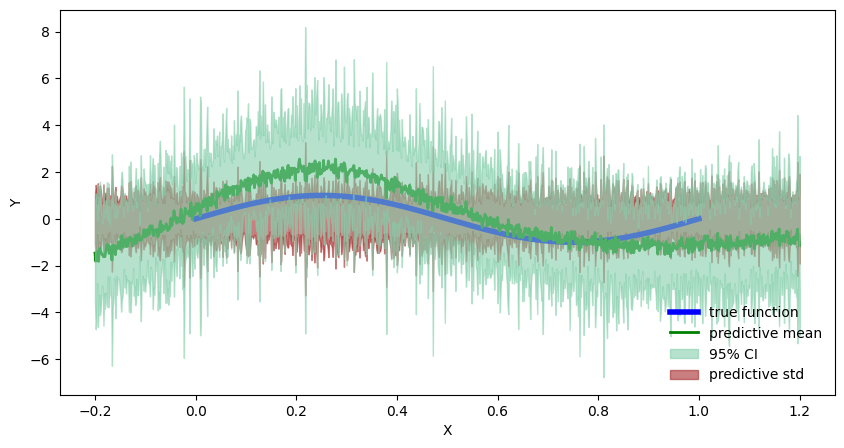

In [94]:
def plot_predictions(preds):
    y_pred = preds['obs'].T.detach().numpy().mean(axis=1)
    y_std = preds['obs'].T.detach().numpy().std(axis=1)

    fig, ax = plt.subplots(figsize=(10, 5))
    plt.xlabel("X")
    plt.ylabel("Y")

    ax.plot(X, y_true, 'b-', linewidth=4, label="true function")
    # ax.plot(X_retained, y_retained, 'ko', markersize=4, label="observations")
    ax.plot(x_test, y_pred, 'g-', linewidth=2, color="green", label="predictive mean")
    ax.fill_between(x_test, y_pred - 2 * y_std, y_pred + 2 * y_std, alpha=0.6, color='#86cfac', zorder=5, label = "95% CI")

    # Plot the standard deviation of the predictions independently as a trace plot
    ax.fill_between(x_test, -y_std, y_std, alpha=0.6, color='brown', label = "predictive std")

    plt.legend(loc=4, frameon=False)

plot_predictions(res)

#### Unlearning using the samples from the original posterior samples

In [32]:
class UnlearningNeuralNet(PyroModule):
    def __init__(self, in_dim=1, out_dim=1, hid_dim=5):
        super().__init__()

        self.activation = nn.Tanh()  # or nn.ReLU()
        self.layer1 = PyroModule[nn.Linear](in_dim, hid_dim)  # Input to hidden layer
        self.layer2 = PyroModule[nn.Linear](hid_dim, out_dim)  # Hidden to output layer

        # Set layer parameters as random variables
        self.layer1.weight = PyroSample(dist.MultivariateNormal(layer1weight_mean, layer1weight_cov).expand([hid_dim, in_dim]).to_event(2))
        self.layer1.bias = PyroSample(dist.Normal(layer1bias_mean, layer1bias_cov).expand([hid_dim]).to_event(1))
        self.layer2.weight = PyroSample(dist.MultivariateNormal(layer2weight_mean, layer2weight_cov).expand([out_dim, hid_dim]).to_event(2))
        self.layer2.bias = PyroSample(dist.Normal(layer2bias_mean, layer2bias_cov).expand([out_dim]).to_event(1))

    def forward(self, x, y=None):
        x = x.reshape(-1, 1)
        x = self.activation(self.layer1(x))
        mu = self.layer2(x).squeeze()
        sigma = pyro.sample("sigma", dist.Gamma(.5, 1))  # Infer the response noise

        # Sampling model
        with pyro.plate("data", x.shape[0]):
            obs = np.exp(10) / pyro.sample("obs", dist.Normal(mu, sigma), obs=y)
        return obs

In [96]:
# unlearned_model = UnlearningNeuralNet()

# Set Pyro random seed
pyro.set_rng_seed(42)

# Define Hamiltonian Monte Carlo (HMC) kernel
# NUTS = "No-U-Turn Sampler" (https://arxiv.org/abs/1111.4246), gives HMC an adaptive step size
# nuts_kernel = NUTS(unlearned_model, jit_compile=False)  # jit_compile=True is faster but requires PyTorch 1.6+
nuts_kernel = NUTS(laplace_model, jit_compile=False)  # jit_compile=True is faster but requires PyTorch 1.6+

# Define MCMC sampler, get 50 posterior samples
mcmc_un = MCMC(nuts_kernel, num_samples=50)

# Run MCMC
mcmc_un.run(X_deleted, y_deleted)

Sample: 100%|██████████| 100/100 [00:00, 110.42it/s, step size=9.32e-01, acc. prob=0.960]


In [97]:
predictive = Predictive(model=laplace_model, posterior_samples=mcmc_un.get_samples())
x_test = torch.linspace(-0.2, 1.2, 1000)
preds = predictive(x_test)

In [98]:
def plot_predictions(preds):
    y_pred = preds['obs'].T.detach().numpy().mean(axis=1)
    y_std = preds['obs'].T.detach().numpy().std(axis=1)

    fig, ax = plt.subplots(figsize=(10, 5))
    plt.xlabel("X")
    plt.ylabel("Y")

    ax.plot(X, y_true, 'b-', linewidth=4, label="true function")
    ax.plot(X_retained, y_retained, 'ko', markersize=4, label="observations")
    ax.plot(X_deleted, y_deleted, 'ro', markersize=4, label="deleted observations")
    ax.plot(x_test, y_pred, 'g-', linewidth=2, color="green", label="predictive mean")
    ax.fill_between(x_test, y_pred - 2 * y_std, y_pred + 2 * y_std, alpha=0.6, color='#86cfac', zorder=5, label = "95% CI")

    # Plot the standard deviation of the predictions independently as a trace plot
    ax.fill_between(x_test, -y_std, y_std, alpha=0.6, color='brown', label = "predictive std")

    plt.legend(loc=4, frameon=False)

C:\Users\nokze\AppData\Local\Temp\ipykernel_8976\2040152849.py:12: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "g-" (-> color='g'). The keyword argument will take precedence.
  ax.plot(x_test, y_pred, 'g-', linewidth=2, color="green", label="predictive mean")


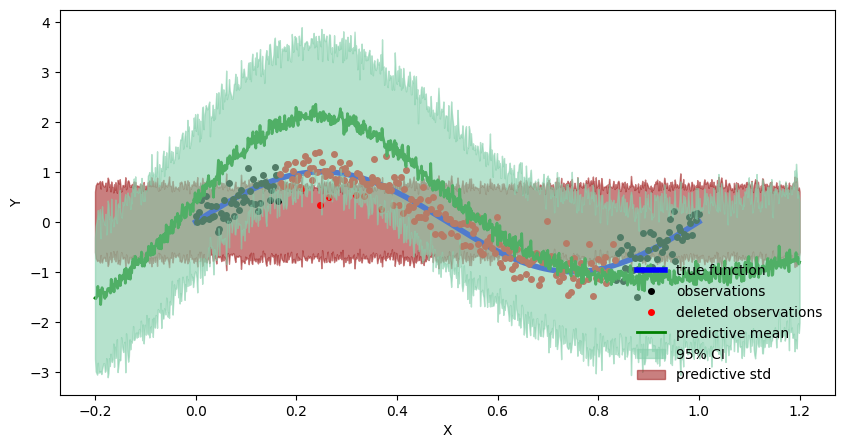

In [99]:
plot_predictions(preds)

#### Using L-BUN on the posterior for unlearning

In [58]:
# Defining the unlearning model
unlearned_model2 = torch.nn.Sequential(
    torch.nn.Linear(1, 5),
    torch.nn.Tanh(),
    torch.nn.Linear(5, 1)
)

In [34]:
list(unlearned_model2.named_parameters())

[('0.weight',
  Parameter containing:
  tensor([[ 0.2972],
          [ 0.4006],
          [ 0.2383],
          [-0.8375],
          [-0.4242]], requires_grad=True)),
 ('0.bias',
  Parameter containing:
  tensor([-0.0813, -0.2547, -0.5707,  0.7648,  0.3818], requires_grad=True)),
 ('2.weight',
  Parameter containing:
  tensor([[-0.0421, -0.0468, -0.4243, -0.2176, -0.1287]], requires_grad=True)),
 ('2.bias',
  Parameter containing:
  tensor([0.0770], requires_grad=True))]

In [59]:
# Update the state dict of the unlearned model with the mean values of the posterior
unlearned_model2.state_dict()['0.weight'][:] = torch.tensor(layer1weight_mean.reshape(5, 1))
unlearned_model2.state_dict()['0.bias'][:] = torch.tensor(layer1bias_mean)
unlearned_model2.state_dict()['2.weight'][:] = torch.tensor(layer2weight_mean)
unlearned_model2.state_dict()['2.bias'][:] = torch.tensor(layer2bias_mean)

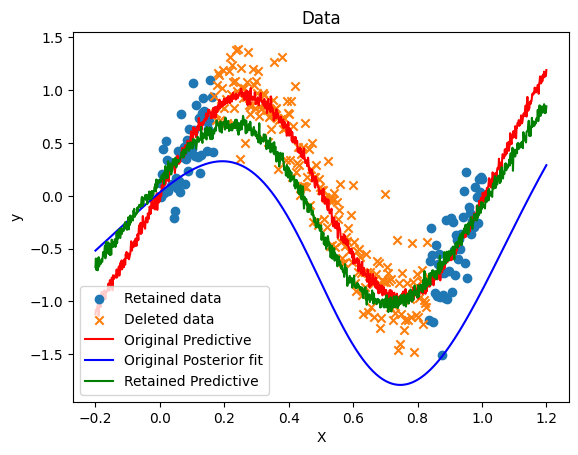

In [53]:
plt.scatter(X_retained, y_retained, label='Retained data')
plt.scatter(X_deleted, y_deleted, marker='x', label='Deleted data')
plt.plot(x_test, model_preds['obs'].T.detach().numpy().mean(axis=1), 'r', label='Original Predictive')
plt.plot(x_test, unlearned_model2(x_test.reshape(-1, 1)).detach().numpy(), 'b-', label='Original Posterior fit')
plt.plot(x_test, ret_model_preds['obs'].T.detach().numpy().mean(axis=1), 'g-', label='Retained Predictive')

plt.xlabel('X')
plt.ylabel('y')
plt.title('Data')
plt.legend()
plt.show()

In [60]:
lambda_L = 1

In [38]:
# Reshape X_deleted and y_deleted into column vector
X_deleted = X_deleted.reshape(-1, 1)
y_deleted = y_deleted.reshape(-1, 1)

In [61]:
# Defining the loss functions for unlearning
def log_likelihood(y_true):
    y_pred = unlearned_model2(X_deleted)
    assert(y_pred.shape == y_true.shape)
    return torch.distributions.Normal(y_pred, scale = 1.0).log_prob(y_true).mean()

def log_q():
    log_prob = 0.0
    for index, params in enumerate(unlearned_model2.parameters()):
        params = params.reshape(-1)
        mean_val = mean_arr[index]
        scale_val = np.sqrt(cov_mat[index][index])
        log_prob += torch.distributions.Normal(mean_val, scale = scale_val).log_prob(params).sum()
    return log_prob / len(mean_arr)

def neg_log_joint(y_true):
    # return -log_likelihood(y_true)
    return log_likelihood(y_true) - lambda_L * log_q()

In [62]:
# Training the model
LR = 0.002
EPOCHS = 5000
optimizer = torch.optim.Adam(unlearned_model2.parameters(), lr=LR)
for i in range(EPOCHS):
    loss = neg_log_joint(y_deleted)
    if(i % 100 == 0):
        print(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

48.21750259399414
42.557945251464844
33.68369674682617
18.60814666748047
-4.797126770019531
-33.898956298828125
-67.23698425292969
-103.67141723632812
-142.38467407226562
-183.1942138671875
-226.11795043945312
-271.199951171875
-318.4720458984375
-367.9501953125
-419.63751220703125
-473.5272216796875
-529.6055297851562
-587.8544921875
-648.2525634765625
-710.7770385742188
-775.4033813476562
-842.1066284179688
-910.8622436523438
-981.64501953125
-1054.431396484375
-1129.197265625
-1205.9193115234375
-1284.5760498046875
-1365.1461181640625
-1447.6090087890625
-1531.9456787109375
-1618.13671875
-1706.165283203125
-1796.0146484375
-1887.6683349609375
-1981.1119384765625
-2076.331298828125
-2173.312255859375
-2272.043212890625
-2372.51171875
-2474.707763671875
-2578.619384765625
-2684.23779296875
-2791.55322265625
-2900.556640625
-3011.2412109375
-3123.597412109375
-3237.61962890625
-3353.299072265625
-3470.63232421875


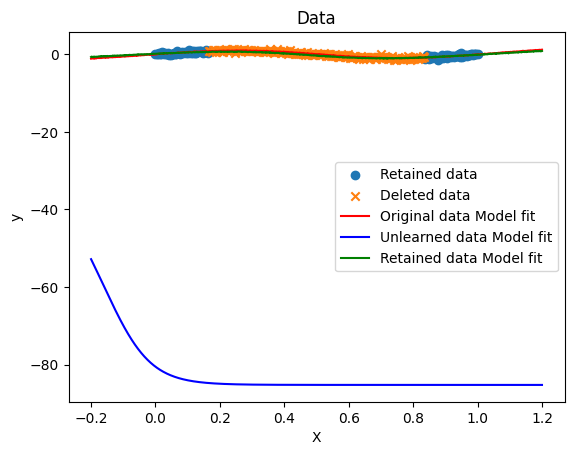

In [63]:
plt.scatter(X_retained, y_retained, label='Retained data')
plt.scatter(X_deleted, y_deleted, marker='x', label='Deleted data')
plt.plot(x_test, model_preds['obs'].T.detach().numpy().mean(axis=1), 'r', label='Original data Model fit')
plt.plot(x_test, unlearned_model2(x_test.reshape(-1, 1)).detach().numpy(), 'b-', label='Unlearned data Model fit')
plt.plot(x_test, ret_model_preds['obs'].T.detach().numpy().mean(axis=1), 'g-', label='Retained data Model fit')

plt.xlabel('X')
plt.ylabel('y')
plt.title('Data')
plt.legend()
plt.show()

In [42]:
print("Unlearned model parameters:")
list(unlearned_model2.parameters())

Unlearned model parameters:


[Parameter containing:
 tensor([[-0.3331],
         [-0.3331],
         [-0.3331],
         [-0.3331],
         [-0.3331]], requires_grad=True),
 Parameter containing:
 tensor([-3.5241, -3.4855, -3.5254, -3.5255, -3.3928], requires_grad=True),
 Parameter containing:
 tensor([[-1.8190, -1.8093, -1.8190, -1.8190, -1.8190]], requires_grad=True),
 Parameter containing:
 tensor([-0.9196], requires_grad=True)]

In [43]:
print("Posterior parameters mean and covariance:")
mean_vals, cov_vals

Posterior parameters mean and covariance:


([array([-0.33305427, -3.525541  , -1.818953  , -0.9196742 , -2.468355  ],
        dtype=float32),
  array([ 0.59104055,  1.7857796 ,  0.07449889, -0.06331678,  2.520763  ],
        dtype=float32),
  array([-0.4185306,  2.8791413, -1.5534548, -0.5732222, -2.576661 ],
        dtype=float32),
  array([0.1563261], dtype=float32)],
 [array([1.2198495 , 0.06946334, 2.48223194, 3.10910979, 0.65661866]),
  array([1.81780441, 0.02156335, 0.13939732, 0.78247849, 0.48527691]),
  array([1.11821824, 0.08838002, 2.24869023, 2.13714745, 0.49121791]),
  array([0.49579456])])